In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CC GENERAL.csv to CC GENERAL.csv


In [ ]:
inp = pd.read_csv('CC GENERAL.csv')
inp.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
inp.dtypes
# Here we can see that all the variables are of numeric type leaving custid . 
# As custid is not needed to train the model so we will not do any transformation on this feature

CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

##### **Looking for missing values**

In [ ]:
inp.apply(lambda x: sum(x.isnull()/len(inp)))

# only two features have null values ‘CREDIT_LIMIT’ and ‘MINIMUM_PAYMENTS’.
# This means that we should be ok to fill these with a sensible replacement value and should still be able to use the feature.

CUST_ID                             0.000000
BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.000112
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    0.034972
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
dtype: float64

##### **Filling missing values**

In [ ]:
df_clean = inp.apply(lambda x: x.fillna(x.value_counts().index[0]))  # this is to fill NaNs with the most frequent value from one column.

NameError: ignored

In [ ]:
# Now we dont have any missing value in the data
df_clean.apply(lambda x: sum(x.isnull()/len(inp)))''

CUST_ID                             0.0
BALANCE                             0.0
BALANCE_FREQUENCY                   0.0
PURCHASES                           0.0
ONEOFF_PURCHASES                    0.0
INSTALLMENTS_PURCHASES              0.0
CASH_ADVANCE                        0.0
PURCHASES_FREQUENCY                 0.0
ONEOFF_PURCHASES_FREQUENCY          0.0
PURCHASES_INSTALLMENTS_FREQUENCY    0.0
CASH_ADVANCE_FREQUENCY              0.0
CASH_ADVANCE_TRX                    0.0
PURCHASES_TRX                       0.0
CREDIT_LIMIT                        0.0
PAYMENTS                            0.0
MINIMUM_PAYMENTS                    0.0
PRC_FULL_PAYMENT                    0.0
TENURE                              0.0
dtype: float64

In [ ]:
# Dropping CUST_ID column as we won’t need this for training.
df_clean = df_clean.drop(['CUST_ID'], axis=1)

##### Feature Scaling

As it is reliant on this distance metric feature scaling is a very important consideration. In the example of the data set I am using let’s take two features PURCHASES_FREQUENCY and BALANCE. The feature PURCHASES_FREQUENCY is a number between 0 and 1, whereas BALANCE as it is a monetary value in this dataset is between £0 and £19,043. These features have very different scales which means that if we don’t normalise them so that they are on the same scale. There are likely to be instances where the algorithm will give more weight to one variable.

The following code scales all the features in the data frame. I am using the min_max_scaler for the first iteration. Different techniques for scaling may have different results.

In [ ]:
from sklearn import preprocessing
x = df_clean.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_clean = pd.DataFrame(x_scaled, columns=df_clean.columns)


In [ ]:
df_clean.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,0.003918,0.000000,1.0
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0


In [ ]:
#I mentioned previously that we need to tell the K-Means algorithm the number of clusters it should use. There are a number of techniques that can be used to find the optimal number.
#For this example, I am going to use the elbow method so named because the chart that it produces is similar in shape to the curve of an elbow. This method computes the sum of squared distances for clusters k. As more clusters are used the variance will reduce until you reach a point at which increasing clusters no longer results in a better model
from sklearn.cluster import KMeans

Sum_of_squared_distance = []
K = range(1,15)
for k in K:
  km = KMeans(n_clusters=k)
  km = km.fit(df_clean)
  Sum_of_squared_distance.append(km.inertia_)  # we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

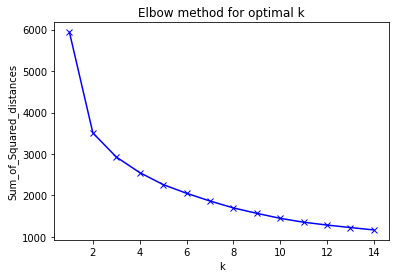

In [ ]:
plt.plot(K, Sum_of_squared_distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_Squared_distances')
plt.title("Elbow method for optimal k")
plt.show()

# You can see that after 8 clusters adding more gives minimal benefit to the model. I am therefore going to use 8 clusters to train my model.

**Training**

In [ ]:
# Before training, I am going to divide the data set into a train and test set.
# below code divides the data reserving 20% for testing.

np.random.seed(0)
msk = np.random.rand(len(df_clean)) < 0.8
train = df_clean[msk]
test = df_clean[~msk]

In [ ]:
# converting both the train and test set into numpy arrays.
X = np.array(train)
X_test = np.array(test)

In [ ]:
# Next, I call the KMeans fit method using 8 clusters.
kMeans = KMeans(n_clusters=8, random_state=0).fit(X)

In [ ]:
# Using the trained model I will now predict the clusters on the test set.
Y_k = kMeans.predict(X_test)

In [ ]:
# I’ll now assign the prediction as a new column on the original test data frame to analyse the results.

test['PREDICTED_cLUSTER'] = Y_k

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Analysing the clusters**

In [ ]:
# I am going to use the pandas groupby function to analyse a selected number of features for the clusters in order to understand if the model has successfully identified unique segments

train_summary = test.groupby(by='PREDICTED_cLUSTER').mean()
train_summary = train_summary[['BALANCE', 'PURCHASES', 
                               'PURCHASES_FREQUENCY','CREDIT_LIMIT', 
                               'ONEOFF_PURCHASES_FREQUENCY', 
                              'MINIMUM_PAYMENTS','PRC_FULL_PAYMENT', 
                               'PAYMENTS']]
train_summary

,BALANCE,PURCHASES,PURCHASES_FREQUENCY,CREDIT_LIMIT,ONEOFF_PURCHASES_FREQUENCY,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,PAYMENTS
PREDICTED_cLUSTER,,,,,,,,
0,0.008697,0.007055,0.160948,0.133629,0.073079,0.002656,0.268398,0.032777
1,0.121154,0.090392,0.973607,0.244215,0.803933,0.010289,0.221812,0.079736
2,0.123316,0.003147,0.071102,0.141185,0.055570,0.014216,0.020536,0.029812
3,0.068851,0.023151,0.946202,0.121323,0.087066,0.014200,0.061945,0.027208
4,0.006536,0.022963,0.862737,0.135101,0.097612,0.002251,0.813015,0.023455
5,0.080853,0.045363,0.860742,0.197321,0.836844,0.008996,0.301056,0.047681
6,0.089313,0.018569,0.531942,0.152739,0.160247,0.014030,0.069644,0.028500
7,0.062364,0.006282,0.152993,0.097713,0.098011,0.004746,0.051367,0.015617
